# Dalhquist's ODE using a parallel-in-time method

Now that we are familiar with Dalhquist's model ODE, we will solve it using the parallel-in-time method ParaDiag.
First, we rewrite Dalhquist's ODE to separate the terms including the solution $q$ on the left hand side, and the forcing term $b$ on the right hand side:

$$
\partial_{t}q(t) - \lambda q(t) = b(t)
$$

The implicit theta method discretisation then looks like:

$$
\frac{q^{n+1}-q^{n}}{\Delta t} - (\theta\lambda q^{n+1} + (1-\theta)\lambda q^{n}) = \theta b(t^{n+1}) + (1-\theta)b(t^{n})
$$

We can now construct the all-at-once system which couples all timesteps in the time-series together into a single problem. For 4 timesteps this looks like:

$$
\left(
\begin{pmatrix}
 1 &  0 &  0 & 0 \\
-1 &  1 &  0 & 0 \\
 0 & -1 &  1 & 0 \\
 0 &  0 & -1 & 1 \\
\end{pmatrix}
\frac{1}{\Delta t}
-
\begin{pmatrix}
\theta     & 0          & 0          & 0 \\
(1-\theta) & \theta     & 0          & 0 \\
0          & (1-\theta) & \theta     & 0 \\
0          & 0          & (1-\theta) & \theta \\
\end{pmatrix}
\lambda
\right)
\begin{pmatrix}
q^{1} \\ q^{2} \\ q^{3} \\ q^{4} \\
\end{pmatrix}
=
\textbf{b}
$$

The left hand side can be written using the two Toeplitz matrices $\textbf{B}_{1}$ and $\textbf{B}_{2}$ which define the implicit theta method:

$$
\textbf{A}\textbf{q} = \left(\textbf{B}_{1}\frac{1}{\Delta t} + \textbf{B}_{2}\left(-\lambda\right)\right)\textbf{q}
$$

Where $\textbf{A}$ is the all-at-once Jacobian, and $\textbf{q}$ is the vector of the timeseries $q^{n}$.

The right hand side vector $\textbf{b}$ contains the forcing terms and the initial condition:

$$
\theta
\begin{pmatrix}
b(t^{1}) \\
b(t^{2}) \\
b(t^{3}) \\
b(t^{4}) \\
\end{pmatrix}
+
(1-\theta)
\begin{pmatrix}
b(t^{0}) \\
b(t^{1}) \\
b(t^{2}) \\
b(t^{3}) \\
\end{pmatrix}
+
\begin{pmatrix}
q^{0}/\Delta t + (1-\theta)\lambda q^{0} \\ 0 \\ 0 \\ 0
\end{pmatrix}
$$

## Implementing the all-at-once system

We start as for the serial method by defining the problem parameters. This time we will need a vector for the time at each timestep.

In [53]:
import numpy as np

T = 102.4
nt = 1024
dt = T/nt
theta = 0.5
lamda = -0.01 + 1.0j
q0 = 1

time = np.linspace(dt, nt*dt, num=nt, endpoint=True)

We will define the right hand side vector $\textbf{b}$ before tackling the all-at-once Jacobian $\textbf{A}$. The forcing function is identical to the serial implementation:

In [54]:
def b(t):
    bb = 0
    bb += 2*np.exp(-(t-9.5)*(t-9.5))
    bb += 0.5*np.exp(-(t-21.3)*(t-21.3)/4)
    bb += -5*np.exp(-(t-48.7)*(t-48.7)/9)
    return bb

The forcing terms in the right hand side vector are:

In [55]:
rhs = np.zeros(nt, dtype=complex)
rhs[1:] += (1-theta)*b(time[:-1])
rhs[:] += theta*b(time[:])

The initial condition term is:

In [56]:
rhs[0] += (1/dt + (1-theta)*lamda)*q0 + (1-theta)*b(0)

Now we can move on to matrices on the left hand side. Toeplitz matrices can be represented using two vectors, one for the first column and one for the first row. For the lower triangular timestepping matrices $\textbf{B}_{1,2}$ these are:

In [57]:
b1col = np.zeros(nt, dtype=complex)
b1col[0] = 1
b1col[1] = -1

b1row = np.zeros_like(b1col)
b1row[0] = b1col[0]

b2col = np.zeros(nt, dtype=complex)
b2col[0] = theta
b2col[1] = 1-theta

b2row = np.zeros_like(b2col)
b2row[0] = b2col[0]

Now we can define the Toeplitz Jacobian matrix $\textbf{A}$:

In [58]:
acol = b1col/dt - b2col*lamda
arow = b1row/dt - b2row*lamda

We will make use of SciPy's sparse linear algebra module. One component we will be using a lot is the [`LinearOperator`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.LinearOperator.html) base class, which is an abstract class representing the action of a matrix on a vector. A class inheriting from `LinearOperator` must implement the `_matvec` method which applies the action of the matrix. This interface means that the matrix does not have to be stored explicitly. Many of SciPy's iterative sparse linear algebra utilities expect a `LinearOperator` instead of the raw matrix.

The first `LinearOperator` we will create is for the all-at-once Jacobian $\textbf{A}$. We will make use of the SciPy function [`matmul_toeplitz`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.matmul_toeplitz.html) which does an efficient matrix multiplication for Toeplitz matrices.

In [59]:
from scipy import linalg
import scipy.sparse.linalg as spla

class ToeplitzLinearOperator(spla.LinearOperator):
    def __init__(self, col, row):
        self.dtype = col.dtype
        self.shape = tuple((len(col), len(row)))
        self.mat = tuple((col, row))

    def _matvec(self, v):
        return linalg.matmul_toeplitz(self.mat, v)

The `dtype` and `shape` members are a required part of the `LinearOperator` interface.
Now we can define the all-at-once Jacobian:

In [60]:
A = ToeplitzLinearOperator(acol, arow)

As a first attempt at solving the all-at-once system we will blindly use [GMRES](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.gmres.html) with no preconditioner. Because we have defined the Jacobian as a `LinearOperator` we can use SciPy's GMRES implementation. At each iteration we will print out the iteration number and the (preconditioned) residual `pr_norm`.

In [61]:
niterations=0
def gmres_callback(pr_norm):
    global niterations
    niterations+=1
    print(f"niterations: {str(niterations).rjust(5,' ')} | residual: {pr_norm}")
    return

y, exit_code = spla.gmres(A, rhs,
                          callback=gmres_callback,
                          callback_type='pr_norm')

niterations:     1 | residual: 0.9530656042276455
niterations:     2 | residual: 0.8863752110087522
niterations:     3 | residual: 0.797690659703107
niterations:     4 | residual: 0.7056570020862166
niterations:     5 | residual: 0.6249473998766011
niterations:     6 | residual: 0.5604503401309239
niterations:     7 | residual: 0.5110895749336635
niterations:     8 | residual: 0.47381276101502595
niterations:     9 | residual: 0.44551580432021465
niterations:    10 | residual: 0.42364841064279357
niterations:    11 | residual: 0.406279026367198
niterations:    12 | residual: 0.3919978255024956
niterations:    13 | residual: 0.3797986085540878
niterations:    14 | residual: 0.368979865306513
niterations:    15 | residual: 0.3590693097650801
niterations:    16 | residual: 0.3497661843864541
niterations:    17 | residual: 0.3408951807312776
niterations:    18 | residual: 0.3323682505735687
niterations:    19 | residual: 0.3241530178046064
niterations:    20 | residual: 0.31624782881457336

niterations:   476 | residual: 0.07468202378766317
niterations:   477 | residual: 0.0745810102227973
niterations:   478 | residual: 0.07448131313756548
niterations:   479 | residual: 0.07438315230109743
niterations:   480 | residual: 0.07429488450624568
niterations:   481 | residual: 0.07420742955813313
niterations:   482 | residual: 0.07411061706215348
niterations:   483 | residual: 0.07401277984854045
niterations:   484 | residual: 0.07391405162205843
niterations:   485 | residual: 0.07381502635256962
niterations:   486 | residual: 0.07371683047535264
niterations:   487 | residual: 0.07361887381641212
niterations:   488 | residual: 0.07352179761491187
niterations:   489 | residual: 0.07342513719555867
niterations:   490 | residual: 0.07332902098677037
niterations:   491 | residual: 0.07323331535194824
niterations:   492 | residual: 0.07313772634971183
niterations:   493 | residual: 0.07304263575622703
niterations:   494 | residual: 0.07294715740617687
niterations:   495 | residual: 0

niterations:   959 | residual: 0.02856004836456128
niterations:   960 | residual: 0.02852741585796083
niterations:   961 | residual: 0.0284950256942227
niterations:   962 | residual: 0.028461797349293015
niterations:   963 | residual: 0.02842819408216123
niterations:   964 | residual: 0.028394581634521736
niterations:   965 | residual: 0.028360977200837433
niterations:   966 | residual: 0.028327327051121128
niterations:   967 | residual: 0.028293898547327265
niterations:   968 | residual: 0.028260440875470454
niterations:   969 | residual: 0.028227157794148083
niterations:   970 | residual: 0.028193937644115524
niterations:   971 | residual: 0.02816079573632737
niterations:   972 | residual: 0.028127751397872432
niterations:   973 | residual: 0.028094777202294138
niterations:   974 | residual: 0.028061820058262174
niterations:   975 | residual: 0.02802901555647519
niterations:   976 | residual: 0.02799611238709802
niterations:   977 | residual: 0.027963271602966373
niterations:   978 |

niterations:  1440 | residual: 0.00018556453259418714
niterations:  1441 | residual: 0.00018477591936073503
niterations:  1442 | residual: 0.0001839931758019026
niterations:  1443 | residual: 0.00018324815337576148
niterations:  1444 | residual: 0.00018258467426967076
niterations:  1445 | residual: 0.00018183269798671548
niterations:  1446 | residual: 0.00018111155243570351
niterations:  1447 | residual: 0.00018040185967781145
niterations:  1448 | residual: 0.00017959489867849272
niterations:  1449 | residual: 0.0001787309706130128
niterations:  1450 | residual: 0.00017774994458029936
niterations:  1451 | residual: 0.0001766621891540877
niterations:  1452 | residual: 0.0001755558649828792
niterations:  1453 | residual: 0.00017438692018779473
niterations:  1454 | residual: 0.00017321532651713218
niterations:  1455 | residual: 0.0001721279582045643
niterations:  1456 | residual: 0.00017085049323017196
niterations:  1457 | residual: 0.00016949706676228803
niterations:  1458 | residual: 0.

In [62]:
print(f"gmres exit code: {exit_code}")
print(f"gmres iterations: {niterations}")
print(f"residual: {linalg.norm(rhs-A.matvec(y))}")

gmres exit code: 0
gmres iterations: 1562
residual: 0.0003250201250507868


Clearly this is an incredibly inefficient solution strategy. In the rest of this notebook we will create an effective preconditioner for the all-at-once Jacobian using diagonalisation.

_You may have noticed that it took more than $N_{t}$ iterations for GMRES to converge, even though this method should converge in at most $n$ iterations for an $n\times n$ matrix. This is because scipy uses a restarted GMRES method with a restart of 20 iterations by default. You can change this using the `restart` kwarg. The `tol` and `atol` kwargs can also be used to control the solver tolerance._

The first preconditioner will be a circulant matrix, which are often good preconditioners for Toeplitz matrices (especially triangular Toeplitz matrices). The circulated version of the all-at-once matrix is:

$$
\begin{pmatrix}
 1 &  0 &  0 & -1 \\
-1 &  1 &  0 & 0 \\
 0 & -1 &  1 & 0 \\
 0 &  0 & -1 & 1 \\
\end{pmatrix}
\frac{1}{\Delta t}
-
\begin{pmatrix}
\theta     & 0          & 0          & (1-\theta) \\
(1-\theta) & \theta     & 0          & 0 \\
0          & (1-\theta) & \theta     & 0 \\
0          & 0          & (1-\theta) & \theta \\
\end{pmatrix}
\lambda
=
\textbf{C}_{1}\frac{1}{\Delta t} - \textbf{C}_{2}\lambda
$$

Which is the all-at-once Jacobian obtained for a time-periodic problem with period `T`. All circulant matrices are simultaneously diagonalisable using the discrete fourier transform (DFT) matrix:

$$
\textbf{C} = \textbf{V}\textbf{D}\textbf{V}^{-1},
\quad\quad
\textbf{D} = \textbf{V}^{-1}\textbf{C}[:,0]
$$

Where $\textbf{V}^{-1}=\textbf{F}$ is the DFT matrix, and $\textbf{D}$ is the (diagonal) matrix of eigenvalues, which are calculated as the Fourier transform of the first column of $\textbf{C}$.
The inverse of a circulant matrix can be efficiently calculated in three steps:
1. Multiplying by the inverse eigenvector matrix (i.e. an FFT)
2. Dividing by the eigenvalue matrix
3. Multiplying by the eigenvector matrix (i.e. an IFFT)

We are now ready to implement our circulant preconditioner. SciPy's GMRES routine will take a `LinearOperator` to use as a preconditioner, so this is what we will create. Finish the class skeleton below by completing the `__init__` method and filling out the `_matvec` method using the steps listed above.

In [63]:
from scipy.fft import fft, ifft

class CirculantLinearOperator(spla.LinearOperator):
    def __init__(self, col):
        self.dtype = col.dtype
        self.shape = tuple((len(col), len(col)))
        # delete below here
        self.col = col
        self.eigvals = fft(col, norm='backward')

    def _matvec(self, v):
        # delete below here
        return ifft(fft(v)/self.eigvals)

Now time to test out our new preconditioner by trying to solve the all-at-once system again:

In [64]:
P = CirculantLinearOperator(acol)

niterations=0

y, exit_code = spla.gmres(A, rhs, M=P,
                          callback=gmres_callback,
                          callback_type='pr_norm')

print(f"gmres exit code: {exit_code}")
print(f"gmres iterations: {niterations}")
print(f"residual: {linalg.norm(rhs-A.matvec(y))}")

niterations:     1 | residual: 0.8438042598016073
niterations:     2 | residual: 2.2921700770943045e-14
gmres exit code: 0
gmres iterations: 2
residual: 7.652245731150436e-13


What an improvement! The system is now solved almost to machine precision after two iterations. Clearly the circulant matrix is a very effective preconditioner for the all-at-once system of the Dalhquist equation. However, notice that the residual barely decreases at the first iteration, then plummets at the second. Can we do better?

_It is possible to show that GMRES for the all-at-once system of a linear scalar ODE preconditioned by the circulant matrix will converge in at most two iterations. Why is this?_

Before trying the next preconditioner, we should check that the solution looks as we expect.

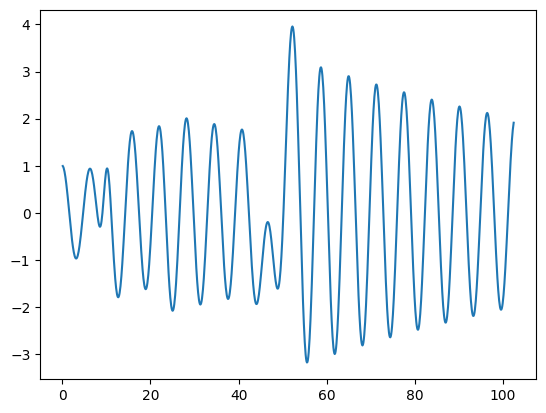

In [67]:
import matplotlib.pyplot as plt

plt.plot(time, y.real)
plt.show()

$\alpha$-circulant matrices are very similar to circulant matrices, except that the circulant entries are scaled by a small parameter $\alpha\in(0,1]$. For our all-at-once system this will look like:

$$
\begin{pmatrix}
 1 &  0 &  0 & -\alpha \\
-1 &  1 &  0 & 0 \\
 0 & -1 &  1 & 0 \\
 0 &  0 & -1 & 1 \\
\end{pmatrix}
\frac{1}{\Delta t}
-
\begin{pmatrix}
\theta     & 0          & 0          & \alpha(1-\theta) \\
(1-\theta) & \theta     & 0          & 0 \\
0          & (1-\theta) & \theta     & 0 \\
0          & 0          & (1-\theta) & \theta \\
\end{pmatrix}
\lambda
=
\textbf{C}^{(\alpha)}_{1}\frac{1}{\Delta t} - \textbf{C}^{(\alpha)}_{2}\lambda
$$

Clearly the standard circulant matrix is recovered when $\alpha=1$. Fortunately for us, just like the standard circulant matrices all $\alpha$-circulant matrices with the same $\alpha$ can be simultaneously diagonalised. The eigendecomposition is still known analytically but is slightly more complicated:

$$
\textbf{C}^{(\alpha)} = \textbf{V}\textbf{D}\textbf{V}^{-1}
$$
where:
$$
\textbf{V}^{-1} = \textbf{F}\Gamma_{\alpha},
\quad
\textbf{D} = \textbf{F}\Gamma_{\alpha}\textbf{C}[:,0]
$$
and $\Gamma_{\alpha}$ is the diagonal matrix:
$$
\Gamma_{\alpha} = \text{diag}\left(\alpha^{\frac{k-1}{N_{t}}}\right)\; \forall k \in [1, N_{t}]
$$

To use this matrix as a preconditioner we will again create a `LinearOperator`. Complete the class skeleton below by finishing the `__init__` method and implementing the `_matvec` method.

In [65]:
class AlphaCirculantLinearOperator(spla.LinearOperator):
    def __init__(self, col, alpha=1):
        self.dtype = col.dtype
        n = len(col)
        self.shape = tuple((n, n))
        # delete below here
        self.alpha = alpha
        self.col = col         

        # fft weighting
        self.gamma = alpha**(np.arange(n)/n)

        # eigenvalues
        self.eigvals = fft(col*self.gamma, norm='backward')

    def _to_eigvecs(self, v): 
        return fft(v*self.gamma, norm='ortho')

    def _from_eigvecs(self, v): 
        return ifft(v, norm='ortho')/self.gamma                            

    def _matvec(self, v): 
        return self._from_eigvecs(self._to_eigvecs(v)/self.eigvals)

Now we can try out our new preconditioner. We can pick some small value of `\alpha` and see how the preconditioner performs.

In [66]:
alpha = 0.1

Pa = AlphaCirculantLinearOperator(acol, alpha)

niterations=0

y, exit_code = spla.gmres(A, rhs, M=Pa,
                          callback=gmres_callback,
                          callback_type='pr_norm')

print(f"gmres exit code: {exit_code}")
print(f"gmres iterations: {niterations}")
print(f"residual: {linalg.norm(rhs-A.matvec(y))}")

niterations:     1 | residual: 0.10420761915720411
niterations:     2 | residual: 4.4708921242081974e-15
gmres exit code: 0
gmres iterations: 2
residual: 5.252430709374086e-13


The solver again converges in two iterations, as expected for the case of a linear scalar ODE, but this time the residual at the first iteration is much smaller. Try different values of $\alpha$ and see how this affects the residuals.
_You might have to reduce the `tol` and `atol` to make sure two iterations are still carried out._